# Week 4 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [4]:
noise = .2

#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [5]:
dfTrain

,vect,category
661,"[0.1631915039371765, -0.5791148828582392]",1
667,"[0.31347540332956747, 0.41654563988594595]",1
844,"[-0.11806147318654459, -0.31864416574109283]",0
365,"[-0.3233529748952861, 0.49982394843197053]",1
237,"[0.5227625829210278, -0.05832951248226009]",1
...,...,...
977,"[-0.41413322172142375, 0.20574442284712924]",1
114,"[-0.13676809859041927, -0.1614583562066346]",0
187,"[0.2176477452721891, 0.6177715598437187]",1
462,"[0.08679220998662086, 0.0422083370962296]",0


So, dfTrain has two columns, vect and category. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


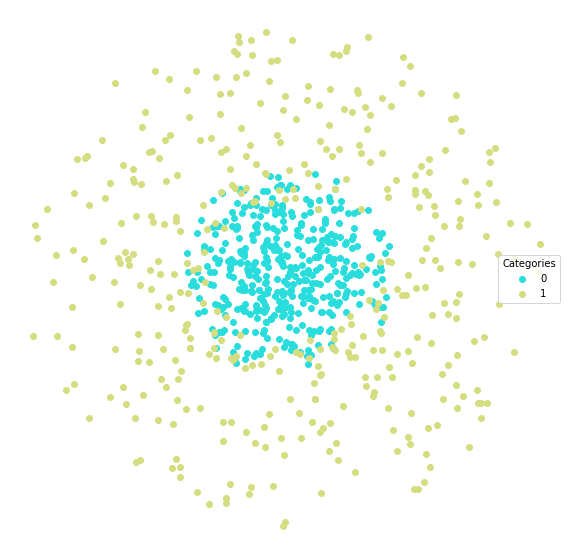

In [7]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [8]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [9]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [10]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [11]:
dfTrain['vect']

661       [0.1631915039371765, -0.5791148828582392]
667      [0.31347540332956747, 0.41654563988594595]
844    [-0.11806147318654459, -0.31864416574109283]
365      [-0.3233529748952861, 0.49982394843197053]
237      [0.5227625829210278, -0.05832951248226009]
                           ...                     
977     [-0.41413322172142375, 0.20574442284712924]
114     [-0.13676809859041927, -0.1614583562066346]
187        [0.2176477452721891, 0.6177715598437187]
462       [0.08679220998662086, 0.0422083370962296]
965       [0.718057882293015, -0.45401620550190536]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [12]:
np.stack(dfTrain['vect'])

array([[ 0.1631915 , -0.57911488],
       [ 0.3134754 ,  0.41654564],
       [-0.11806147, -0.31864417],
       ...,
       [ 0.21764775,  0.61777156],
       [ 0.08679221,  0.04220834],
       [ 0.71805788, -0.45401621]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [14]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.105,0.900468,0.836735,0.813646,0.942529
1,0.105,0.900468,0.950980,0.896328,0.858407


This lets us look at which classes do better:

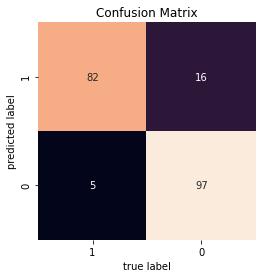

In [15]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

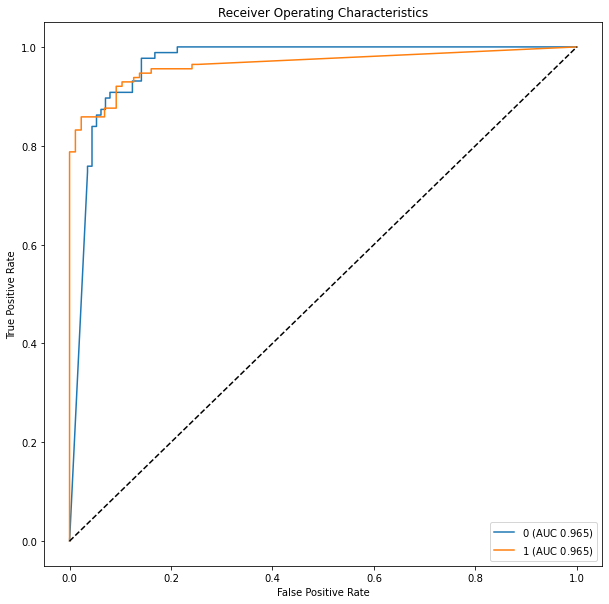

In [16]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


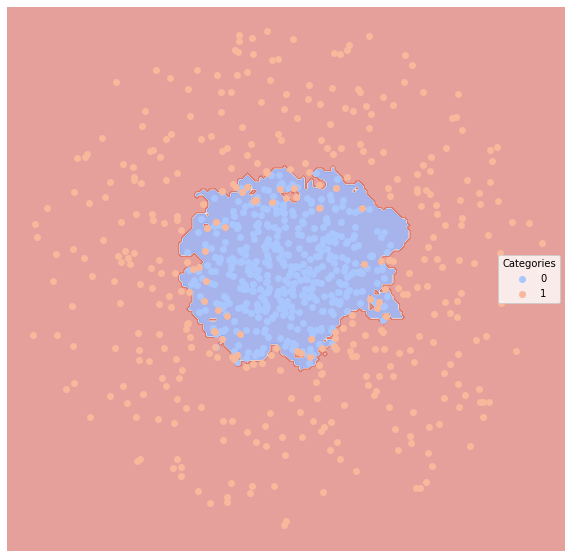

In [17]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [18]:
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors


In [19]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [20]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB()

In [22]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.150470,0.885552,0.653846,0.640960,0.965909
Relationships,0.150470,0.740405,0.672727,0.465550,0.552239
Bad Roommates,0.141066,0.778497,0.734375,0.547983,0.626667
Tales From Tech Support,0.078370,0.869883,0.957143,0.789511,0.752809


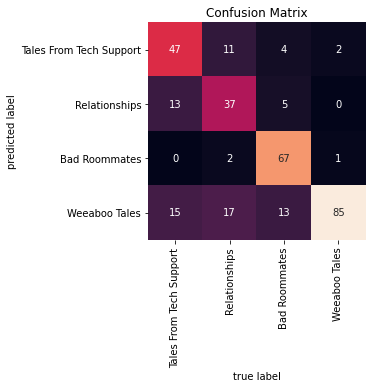

In [23]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

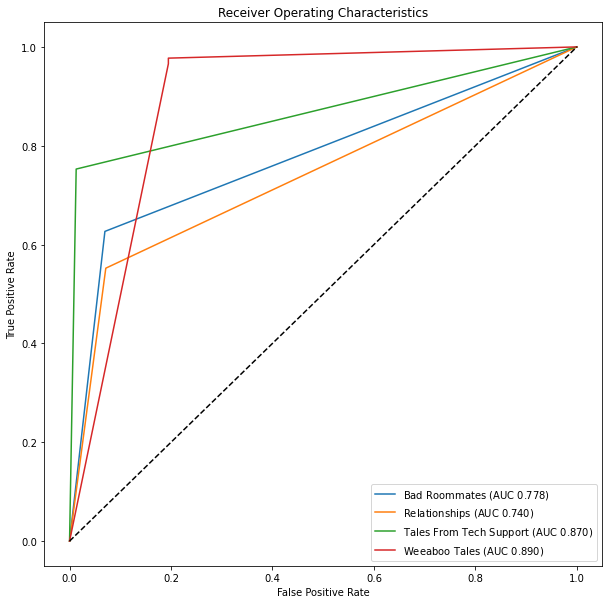

In [24]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

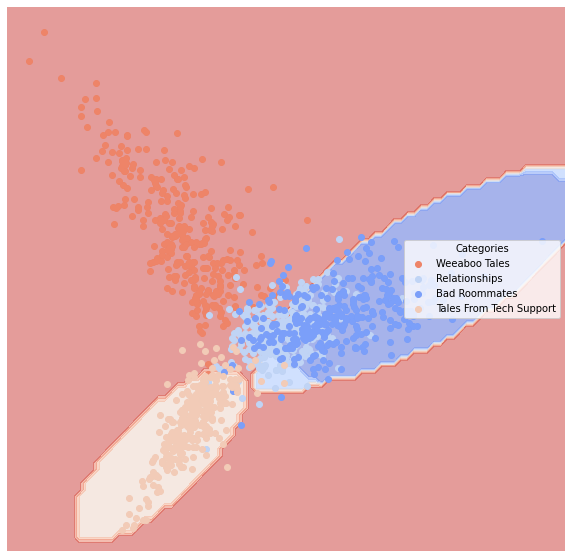

In [25]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [33]:
from sklearn import datasets
np.random.seed(11111)
noise = 0.2
dfTrain_1, dfTest_1 = lucem_illud.trainTestSplit(lucem_illud.random())
dfTrain_2, dfTest_2 = lucem_illud.trainTestSplit(lucem_illud.random())
dfTrain_3, dfTest_3 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
dfTrain_4, dfTest_4 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
dfTrain_5, dfTest_5 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise))
dfTrain_6, dfTest_6 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise))
dfTrain_7, dfTest_7 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
dfTrain_8, dfTest_8 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
dfTrain_9, dfTest_9 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))
dfTrain_10, dfTest_10 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))
trains = [dfTrain_1,dfTrain_2,dfTrain_3,dfTrain_4,dfTrain_5,dfTrain_6,dfTrain_7,dfTrain_8,dfTrain_9,dfTrain_10]
tests = [dfTest_1,dfTest_2,dfTest_3,dfTest_4,dfTest_5,dfTest_6,dfTest_7,dfTest_8,dfTest_9,dfTest_10]

#Bayes
clf_bayes = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf_svc_linear = sklearn.svm.SVC(kernel = 'linear', probability = False) 
clf_svc_poly = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = False)
clf_knn = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')

#Classical Regression
clf_reg_linear = sklearn.linear_model.LogisticRegression()

#Symbolists
clf_dt = sklearn.tree.DecisionTreeClassifier()
clf_rf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf_nn = sklearn.neural_network.MLPClassifier()

#Ensemble
clf_ensemble = sklearn.ensemble.GradientBoostingClassifier()

algos_list = [clf_bayes, clf_svc_linear,clf_svc_poly,clf_knn,clf_reg_linear,clf_dt,clf_rf,clf_nn,clf_ensemble]
algos_names = ['Naive Bayes','linear SVC','poly SVC', 'KNN','linear regression','decision tree','random forest','neural network','ensemble']

In [41]:
#get the algorithm performances and the optimal results of a dataset
def get_best_algo(train,test):
    results = {'algo':[],'accuracy':[]}
    for i,algo in enumerate(algos_list):
        results['algo'].append(algos_names[i])
        fitted_algo = algo.fit(np.stack(train['vect'], axis=0), train['category'])
        scores = lucem_illud.evaluateClassifier(fitted_algo, test)
        results['accuracy'].append(1 - scores.Error_Rate.mean())
        print(algo)
        print(scores)
        print('------------------------------------------')
    results = pandas.DataFrame(results).sort_values(by="accuracy",ascending=False) 
    optimal = [results.iloc[0,0],results.iloc[0,1]]
    return results,optimal

In [35]:
import warnings
warnings.filterwarnings("ignore")

#combine the results of 10 artificial datasets together
optimals = {'dataset':[],'algorithm':[],'accuracy':[]}
for i in range(0,10):
    result = get_best_algo(trains[i],tests[i])[1]
    optimals['dataset'].append(i+1)
    optimals['algorithm'].append(result[0])
    optimals['accuracy'].append(result[1])
optimals_artificial = pandas.DataFrame(optimals)
optimals_artificial

,dataset,algorithm,accuracy
0,1,poly SVC,0.5500
1,2,decision tree,0.5450
2,3,ensemble,0.9400
3,4,poly SVC,0.9050
4,5,neural network,0.9250
5,6,neural network,0.9150
6,7,Naive Bayes,0.9250
7,8,Naive Bayes,0.8800
8,9,Naive Bayes,0.9992
9,10,random forest,0.9944


From the dataframe above, we can see the best algorithm for each artificial datasets. We choose the best algorithm based on the accuracy = (TP + TN)/total. Moroever, for the datasets generated from the same underlying distribution, *(e.g. dataset 1 and 2, 3 and 4, ... ) the best algorithm sometimes changes. Additionally, completely random dataset gets teh lowest accuracy. This is quite reasonable as we cannot distinguish the categories by design. The multiBlobs data pattern has the highest accuracy among all the distributions. This dataset is generated by placing 5 classes as multi-varaite Guassians at random locations.

In [ ]:
#get the datasets
dfTrain_reddit, dfTest_reddit = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
dfTrain_news, dfTest_news = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
dfTrain_small, dfTest_small = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
dfTrain_large, dfTest_large = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())

In [38]:
dfTrain_spam, dfTest_spam = lucem_illud.trainTestSplit(lucem_illud.loadSpam())
trains_real = [dfTrain_reddit,dfTrain_news,dfTrain_small,dfTrain_large,dfTrain_spam]
tests_real = [dfTest_reddit,dfTest_news,dfTest_small,dfTest_large,dfTest_spam]

Loading Spam
Loading Ham
Converting to vectors


In [42]:
#combine the results of 10 real datasets together
optimals_real = {'dataset':[],'algorithm':[],'accuracy':[]}
dataset_names = ['Reddit', 'NewsGroups', 'SenateSmall', 'SenateLarge', 'Spam']
for i in range(0,5):
    print(i)
    result = get_best_algo(trains_real[i],tests_real[i])[1]
    optimals_real['dataset'].append(dataset_names[i])
    optimals_real['algorithm'].append(result[0])
    optimals_real['accuracy'].append(result[1])
optimals_real = pandas.DataFrame(optimals_real)
optimals_real

0
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Weeaboo Tales              0.210031  0.832936   0.478632           0.451122   
Relationships              0.191223  0.700825   0.672414           0.455416   
Bad Roommates              0.159875  0.756184   0.765625           0.554213   
Tales From Tech Support    0.090909  0.870373   0.887500           0.755141   

                           Recall  
Category                           
Weeaboo Tales            0.903226  
Relationships            0.481481  
Bad Roommates            0.576471  
Tales From Tech Support  0.780220  
------------------------------------------
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Weeaboo Tales              0.003135  0.991935   1.000000           0.987006   
Relationships              

                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.236170  0.526209   0.700000           0.272396   
comp.sys.mac.hardware    0.463830  0.535383   0.244444           0.232656   
rec.autos                0.487234  0.486496   0.272727           0.279841   
comp.windows.x           0.234043  0.559250   0.653846           0.309092   

                         Recall  
Category                         
misc.forsale           0.060870  
comp.sys.mac.hardware  0.533981  
rec.autos              0.425373  
comp.windows.x         0.144068  
------------------------------------------
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.057447  0.900245   0.940000           0.813029   
comp.sys.mac.hardware    0.046809  0.928124   0.900990     

           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Kohl         0.051282  0.701493   1.000000           0.454267  0.402985
Kerry        0.139744  0.755004   0.886179           0.595292  0.534314
Kennedy      0.288462  0.740682   0.606115           0.603205  0.982507
Kyl          0.074359  0.707071   1.000000           0.488500  0.414141
Klobuchar    0.043590  0.746269   1.000000           0.536127  0.492537
------------------------------------------
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Kohl         0.033333  0.826254   0.936170           0.644286  0.656716
Kerry        0.137179  0.777318   0.829932           0.601460  0.598039
Kennedy      0.180769  0.834910   0.719565           0.709776  0.965015
Kyl          0.044872  0.823232   1.000000           0.691336  0.646465
Klobuchar    0.032051

,dataset,algorithm,accuracy
0,Reddit,linear SVC,0.993730
1,NewsGroups,linear regression,0.948936
2,SenateSmall,linear SVC,0.994135
3,SenateLarge,decision tree,1.000000
4,Spam,random forest,0.934211


In the above dataframe, we can see the best algorithms for different real-world datasets. Similarly to the exercise with artificial datasets, the criterion for choosing the best algorithm is accuracy = (TP+TN)/total. We can see that the classification accuracy for these real-world datasets are very high. This suggest that there are significant patterns in data that can be distinguished via algorithms. Furthermore, for different datasets, the best algorithms differ. For Reddit, SenateSmall, and SenateLarge, the algorithm can nearly achieve perfect classification. This suggests using certain words as predictors, one can predict with high confidence it belongs to certain category.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [63]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [64]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [65]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [66]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [68]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [70]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [71]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [72]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [73]:
TFVects.shape

(1368, 11427)

We can save this in the dataframe to make things easier

In [74]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [82]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [83]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


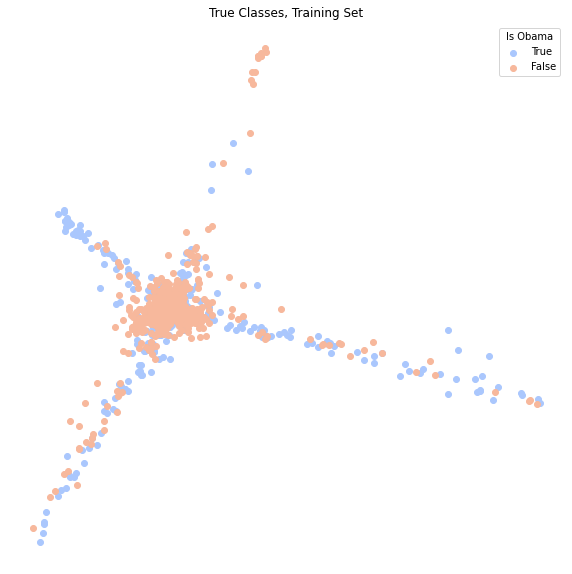

In [84]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

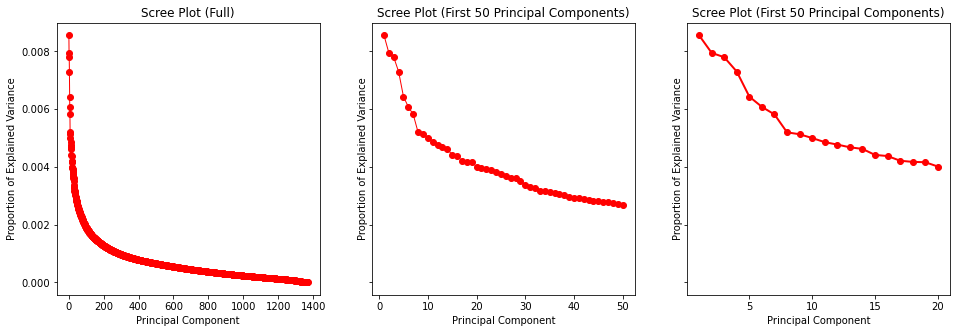

In [85]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [86]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [87]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [88]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6681286549707602

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [89]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6803519061583577

Slightly poorer. How about using more dimensions (40)?

In [90]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7595029239766082
Testing:
0.7360703812316716


Or still more (100)?

In [91]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8421052631578947
Testing:
0.7947214076246334


Or even more (200)!

In [92]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8823099415204678
Testing:
0.8093841642228738


This is becoming ridiculous (400)!

In [93]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9261695906432749
Testing:
0.8328445747800587


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [94]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9649122807017544


Train the model using training data, and then test it on the testing data.

In [95]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.844574780058651


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [96]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB()

In [97]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9736842105263158
Testing:
0.8826979472140762


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [98]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [99]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8571428571428571

Recall:

In [100]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8307692307692308

F1-measure:

In [101]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.84375

Let's take a look at how well our posterior distribution looks relative to the truth.

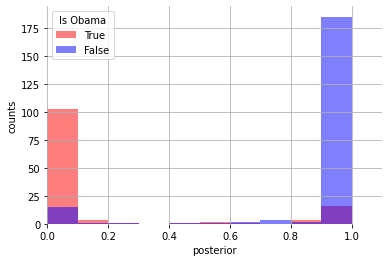

In [102]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [103]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,signature,-2.173488,5566,-1.749630
1,fy,-2.266579,amy,-1.800403
2,welcomed,-2.266579,dick,-1.821456
3,awarded,-2.278849,brundage,-1.876114
4,urban,-2.369233,monday,-1.922100
5,class,-2.410618,chicago,-2.020945
6,expected,-2.410618,reform,-2.160058
7,growing,-2.410618,temporary,-2.205868
8,having,-2.410618,political,-2.221616
9,ground,-2.424803,location,-2.270406


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [104]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [105]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [107]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [109]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [110]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [111]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [112]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB()

...and save predictions to the dataframe:

In [113]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8862449216482878


In [114]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1538,sci.space,sci.space
1748,comp.graphics,comp.graphics
1363,sci.space,sci.space
864,soc.religion.christian,soc.religion.christian
283,talk.religion.misc,soc.religion.christian
1991,comp.graphics,comp.graphics
977,sci.space,sci.space
465,soc.religion.christian,soc.religion.christian
705,soc.religion.christian,soc.religion.christian
1229,sci.space,sci.space


Looks pretty good, lets examine the testing dataset:

In [115]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7744186046511627


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

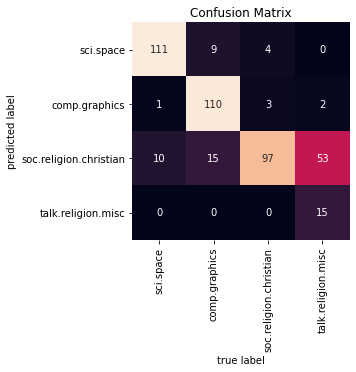

In [117]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [120]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.8463357144704895
0.7744186046511627
0.755904315151002


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [121]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.069767,0.900313,0.948276,0.834249,0.820896
soc.religion.christian,0.197674,0.846714,0.554286,0.533257,0.932692
talk.religion.misc,0.127907,0.607143,1.000000,0.342193,0.214286
comp.graphics,0.055814,0.933814,0.895161,0.840031,0.909836


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

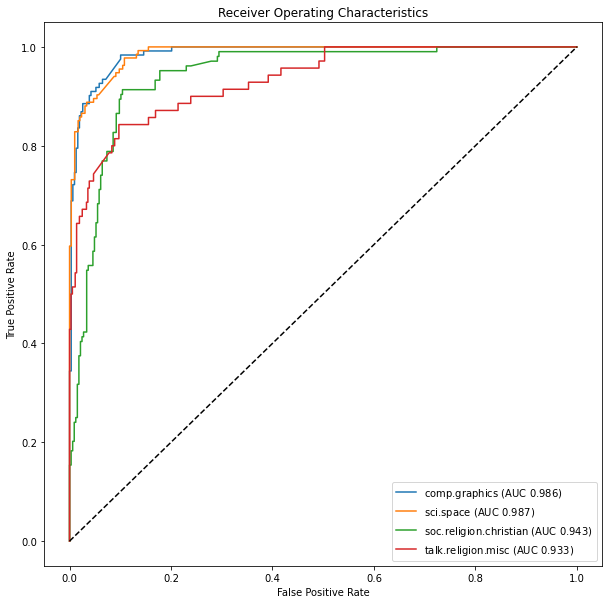

In [122]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

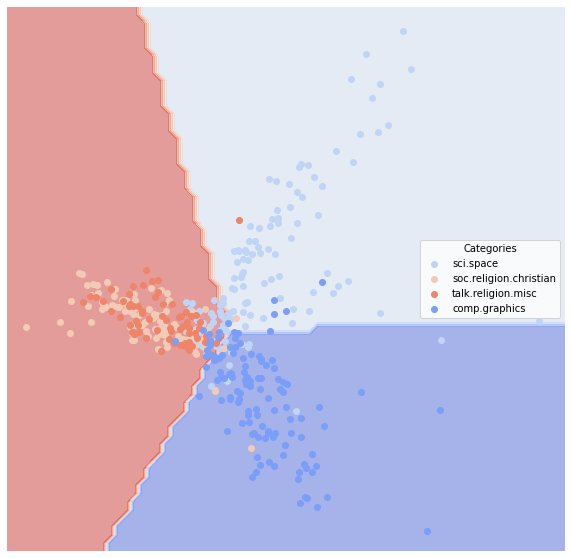

In [123]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


Here I want to explore the predictive power of the sentiment charged words from company annual reports on stock returns. I gathered the company annual announcements from juchao.com which is the official platform for company disclosure in China. There are around 30000 documents in total.

I linked the announcement with stock cumulative returns around a window of 3 days around the announcement date. After that, I used the marginal screening in [Ke et al 2019](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3389884) to get a list of 9336 sentiment-charged words that are related to stock returns. After that, each annual report is converted into a vector of length 9336 with its i-th element corresponding to the number of times the i-th word in my sentiment dictionary occurring in the document.

Each article can be categorized into relating to positive returns or negative returns. I will build classifier for company announcements and see their relationship with stock returns.

For the training, testing split, since there is ample amount of data, I have used 95%:5% split. In this way, there is still around 1500 documents for assessting the out-of-sample performance


In [45]:
len(df_ret.iloc[0,1])

9336

In [2]:
import pandas as pd
df_ret = pd.read_pickle('ann_ret_v2.pkl')

In [3]:
df_ret

,aid,vect,ret,category
0,59524236,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.046662,negative
1,59370917,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.104918,positive
2,59370877,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.034182,positive
3,59370780,"[0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 82...",-0.039908,negative
4,59371082,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.068908,positive
...,...,...,...,...
26661,1206125564,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.137838,negative
26662,1206020868,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.215656,negative
26663,1204501725,"[0, 0, 0, 0, 0, 1, 0, 2, 5, 4, 140, 0, 7, 5, 4...",-0.005848,negative
26664,1205931277,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.009000,positive


In [4]:
xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(df_ret.iloc[:,1], df_ret.iloc[:,-1], 
                                                                        test_size = 0.05, random_state = 111)

In [5]:
coded_ret_train = pandas.DataFrame({'vect':xTrain,'ret':yTrain}) #train data
coded_ret_test = pandas.DataFrame({'vect':xTest,'ret':yTest}) #test data

### Logistic regression

In [174]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(coded_ret_train['vect'], axis=0))
coded_ret_train['pca'] = [r for r in reduced_data]

In [176]:
coded_ret_train

,vect,ret,pca
3918,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative,"[-299.3431762343293, 17.279132462561897, -105...."
20162,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative,"[42.639317834415195, -241.2138078091234, -70.8..."
5065,"[0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 4, 1, ...",negative,"[-523.9048756931937, -21.123429135898558, -21...."
7447,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 20, 0, 2, 0, 2,...",negative,"[-366.77591550053324, 305.04450699754085, 207...."
20245,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative,"[-0.6384748731596979, -232.04436346320026, 81...."
...,...,...,...
7443,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...",negative,"[-600.633021252155, 44.32130399052005, 67.9970..."
4182,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative,"[94.70953992285283, 193.0564255116511, -19.442..."
4820,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",positive,"[-113.81177929030915, 356.1330831646704, 273.8..."
10196,"[19, 0, 1, 0, 0, 6, 3, 3, 3, 2, 7, 0, 7, 7, 1,...",negative,"[-629.3747956738638, 66.89461324681557, -50.26..."


In [177]:
reduced_data_test = pca.transform(np.stack(coded_ret_test['vect'], axis=0))
coded_ret_test['pca'] = [r for r in reduced_data_test]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


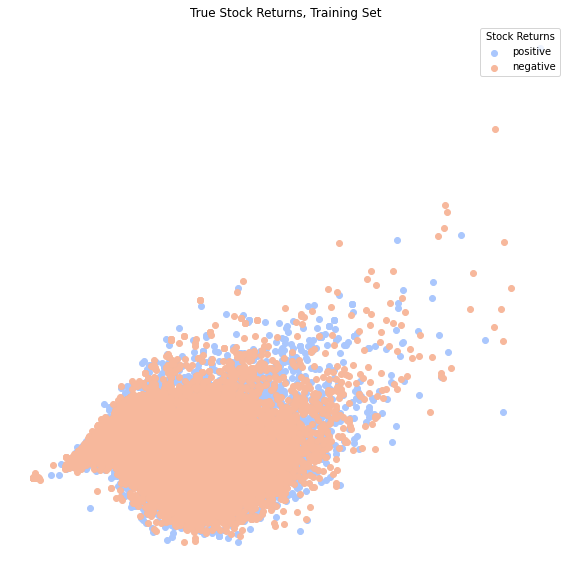

In [178]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot postive reviews
a = np.stack(coded_ret_train[coded_ret_train['ret'] == 'positive']['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "positive")

#Plot negative reviews
a = np.stack(coded_ret_train[coded_ret_train['ret'] == 'negative']['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "negative")
    
ax.legend(loc = 'upper right', title = 'Stock Returns')
plt.title('True Stock Returns, Training Set')
plt.show()

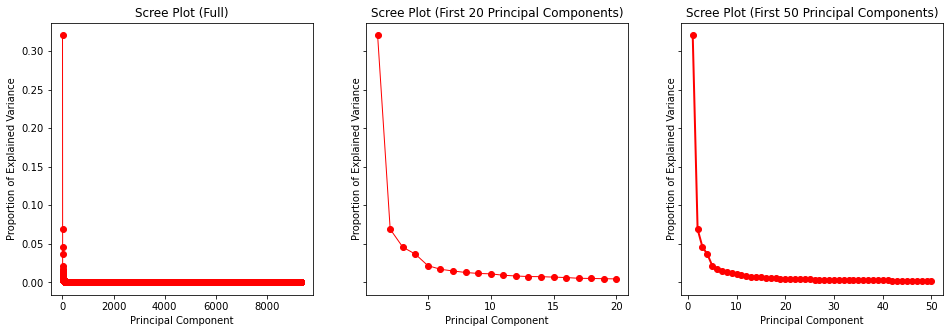

In [180]:
n = len(pca.explained_variance_ratio_)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(50) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [182]:
coded_ret_train['pca_reduced_5'] = coded_ret_train['pca'].apply(lambda x: x[:5])
coded_ret_train['pca_reduced_20'] = coded_ret_train['pca'].apply(lambda x: x[:20])
coded_ret_train['pca_reduced_50'] = coded_ret_train['pca'].apply(lambda x: x[:50])
coded_ret_train['pca_reduced_100'] = coded_ret_train['pca'].apply(lambda x: x[:200])
coded_ret_train['pca_reduced_500'] = coded_ret_train['pca'].apply(lambda x: x[:500])
coded_ret_test['pca_reduced_5'] = coded_ret_test['pca'].apply(lambda x: x[:5])
coded_ret_test['pca_reduced_20'] = coded_ret_test['pca'].apply(lambda x: x[:20])
coded_ret_test['pca_reduced_50'] = coded_ret_test['pca'].apply(lambda x: x[:50])
coded_ret_test['pca_reduced_100'] = coded_ret_test['pca'].apply(lambda x: x[:200])
coded_ret_test['pca_reduced_500'] = coded_ret_test['pca'].apply(lambda x: x[:500])

In [185]:
pca_lists = ['pca_reduced_5','pca_reduced_20','pca_reduced_50','pca_reduced_100','pca_reduced_500']
logistic_scores = {'principle components':[5,20,50,100,500],'training score':[],'testing score':[]}
for pca_list in pca_lists:
    logistic = sklearn.linear_model.LogisticRegression()
    logistic.fit(np.stack(coded_ret_train[pca_list], axis=0), coded_ret_train['ret'])
    training_score = logistic.score(np.stack(coded_ret_train[pca_list], axis=0), coded_ret_train['ret'])
    testing_score = logistic.score(np.stack(coded_ret_test[pca_list], axis=0), coded_ret_test['ret'])
    logistic_scores['training score'].append(training_score)
    logistic_scores['testing score'].append(testing_score)
logistic_scores

{'principle components': [5, 20, 50, 100, 500],
 'training score': [0.5622532764882362,
  0.5674640770566872,
  0.5780830570030001,
  0.6214274435496605,
  0.6525343439128375],
 'testing score': [0.5524737631184408,
  0.5569715142428786,
  0.5697151424287856,
  0.6026986506746627,
  0.6086956521739131]}

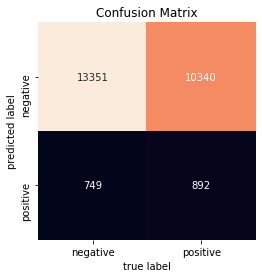

In [187]:
coded_ret_5_components_train = coded_ret_train.copy()
coded_ret_5_components_train['category'] = coded_ret_5_components_train['ret']
coded_ret_5_components_train['vect'] = coded_ret_5_components_train['pca_reduced_5']
logistic_5_components = sklearn.linear_model.LogisticRegression()
logistic_5_components.fit(np.stack(coded_ret_5_components_train['vect'], axis=0), coded_ret_5_components_train['category'])
lucem_illud.plotConfusionMatrix(logistic_5_components, coded_ret_5_components_train)

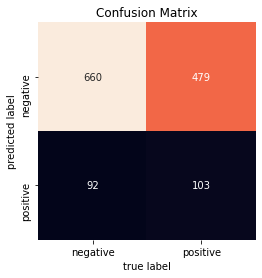

In [189]:
coded_ret_5_components_test = coded_ret_test.copy()
coded_ret_5_components_test['category'] = coded_ret_5_components_test['ret']
coded_ret_5_components_test['vect'] = coded_ret_5_components_test['pca_reduced_5']
logistic_5_components = sklearn.linear_model.LogisticRegression()
logistic_5_components.fit(np.stack(coded_ret_5_components_test['vect'], axis=0), coded_ret_5_components_test['category'])
lucem_illud.plotConfusionMatrix(logistic_5_components, coded_ret_5_components_test)

In [ ]:
logistic_ret= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_ret.fit(np.stack(coded_ret_train['vect'], axis=0), coded_ret_train['ret'])

In [192]:
print('training: ', logistic_ret.score(np.stack(coded_ret_train['vect'], axis=0), coded_ret_train['ret']))
print('testing: ', logistic_ret.score(np.stack(coded_ret_test['vect'], axis=0), coded_ret_test['ret']))

training:  0.7313279646297174
testing:  0.6761619190404797


It seems that PCA does not help too much for classification compared to using the raw data.

### Naïve Bayes classification

In [6]:
coded_ret_train_bayes = coded_ret_train.copy()
coded_ret_test_bayes = coded_ret_test.copy()
coded_ret_train_bayes['category'] = coded_ret_train_bayes['ret']
coded_ret_test_bayes['category'] = coded_ret_test_bayes['ret']

In [7]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(coded_ret_train_bayes['vect'], axis=0), coded_ret_train_bayes['ret'])
print("Training:")
print(naiveBayes.score(np.stack(coded_ret_train_bayes['vect'], axis=0), coded_ret_train_bayes['ret']))
print("Testing:")
print(naiveBayes.score(np.stack(coded_ret_test_bayes['vect'], axis=0), coded_ret_test_bayes['ret']))

Training:
0.5708589925785568
Testing:
0.5622188905547226


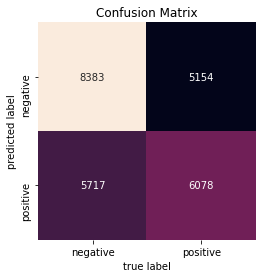

In [8]:
lucem_illud.plotConfusionMatrix(naiveBayes, coded_ret_train_bayes)

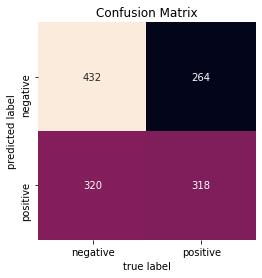

In [9]:
lucem_illud.plotConfusionMatrix(naiveBayes, coded_ret_test_bayes)

In [198]:
coded_ret_train_bayes['nb_predict'] = naiveBayes.predict(np.stack(coded_ret_train_bayes['vect'], axis=0))
coded_ret_train_bayes['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(coded_ret_train_bayes['vect'], axis=0))[:,0]
coded_ret_test_bayes['nb_predict'] = naiveBayes.predict(np.stack(coded_ret_test_bayes['vect'], axis=0))
coded_ret_test_bayes['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(coded_ret_test_bayes['vect'], axis=0))[:,0]

#### Precision

In [199]:
print('Training:')
print(sklearn.metrics.precision_score(coded_ret_train_bayes['category'], coded_ret_train_bayes['nb_predict'],pos_label="positive"))
print('Testing:')
print(sklearn.metrics.precision_score(coded_ret_test_bayes['category'], coded_ret_test_bayes['nb_predict'],pos_label="positive"))

Training:
0.5153030945315812
Testing:
0.49843260188087773


#### Recall

In [200]:
print('Training:')
print(sklearn.metrics.recall_score(coded_ret_train_bayes['category'], coded_ret_train_bayes['nb_predict'],pos_label="positive"))
print('Testing:')
print(sklearn.metrics.recall_score(coded_ret_test_bayes['category'], coded_ret_test_bayes['nb_predict'],pos_label="positive"))

Training:
0.5411324786324786
Testing:
0.5463917525773195


#### F1-measure

In [201]:
print('Training:')
print(sklearn.metrics.f1_score(coded_ret_train_bayes['category'], coded_ret_train_bayes['nb_predict'],pos_label="positive"))
print('Testing:')
print(sklearn.metrics.f1_score(coded_ret_test_bayes['category'], coded_ret_test_bayes['nb_predict'],pos_label="positive"))

Training:
0.5279020280540234
Testing:
0.521311475409836


#### AUC (together with other measures)

In [202]:
# Training
lucem_illud.metrics.evaluateClassifier(naiveBayes, coded_ret_train_bayes)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
positive,0.429141,0.567836,0.515303,0.482305,0.541132
negative,0.429141,0.567836,0.619266,0.593861,0.594539


In [203]:
# Testing
lucem_illud.metrics.evaluateClassifier(naiveBayes, coded_ret_test_bayes)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
positive,0.437781,0.56043,0.498433,0.470241,0.546392
negative,0.437781,0.56043,0.620690,0.596446,0.574468


#### ROC

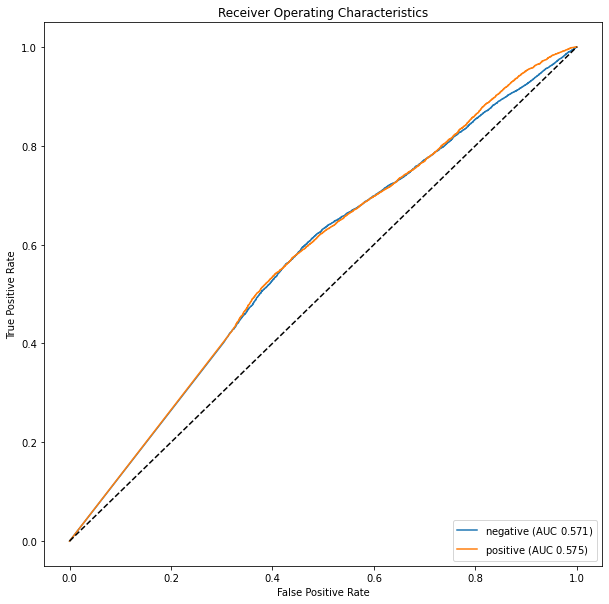

In [204]:
# Training
lucem_illud.plotMultiROC(naiveBayes, coded_ret_train_bayes)

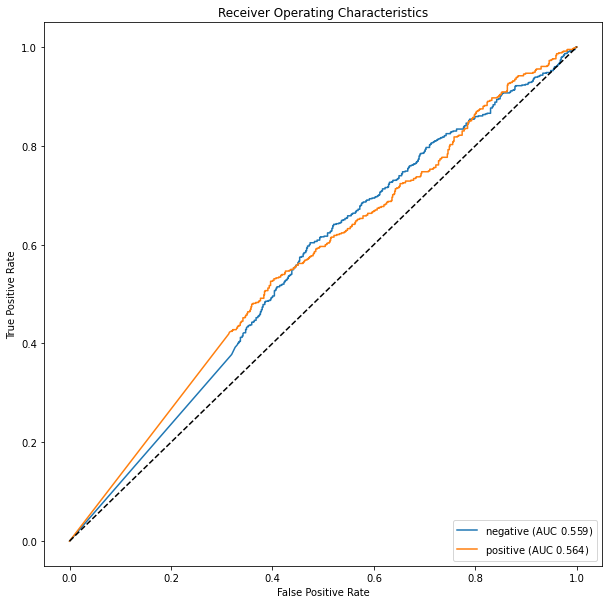

In [205]:
# Testing
lucem_illud.plotMultiROC(naiveBayes, coded_ret_test_bayes)

The performance of Naive Bayes is also very poor.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

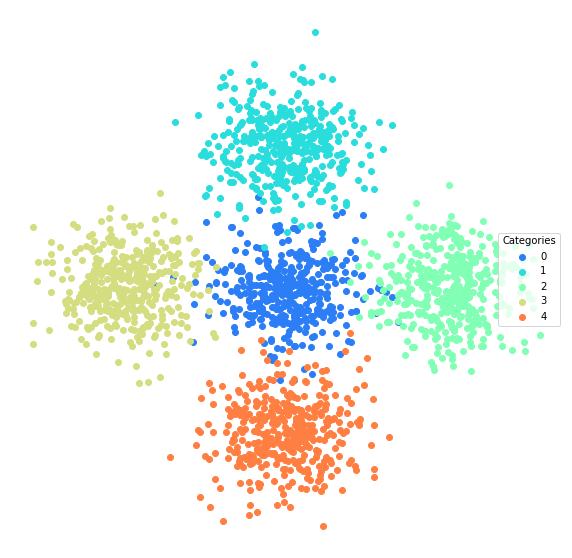

In [125]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [126]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

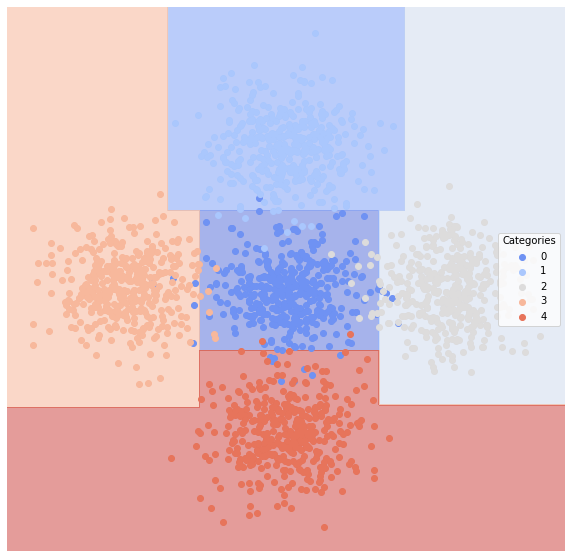

In [128]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [129]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.961599,0.945652,0.896642,0.935484
1,0.006,0.992745,0.981308,0.974051,0.990566
2,0.002,0.998765,0.989583,0.989583,1.000000
3,0.006,0.984848,1.000000,0.975697,0.969697
4,0.012,0.985565,0.963303,0.949297,0.981308


Lets look at accuracy:

In [130]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.976

What happens if we trim the tree?

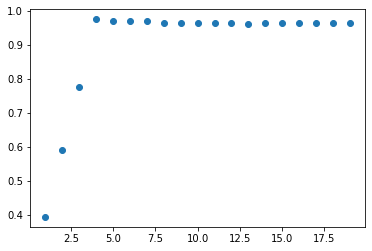

In [131]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [132]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [133]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

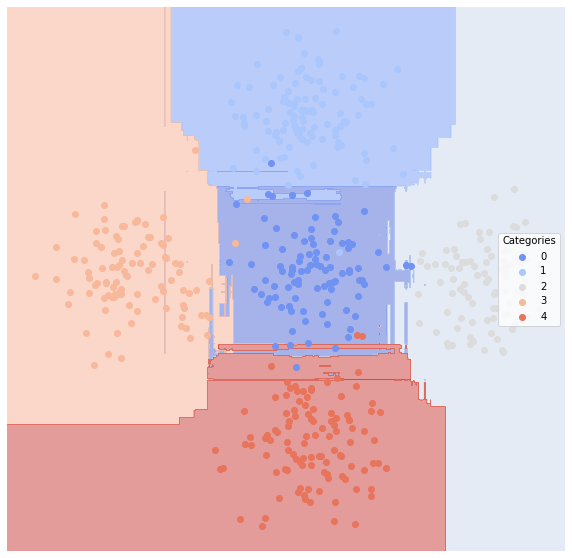

In [134]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [135]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.028,0.945470,0.943820,0.870483,0.903226
1,0.014,0.984221,0.954128,0.940126,0.981132
2,0.002,0.998765,0.989583,0.989583,1.000000
3,0.004,0.989899,1.000000,0.983798,0.979798
4,0.012,0.985565,0.963303,0.949297,0.981308


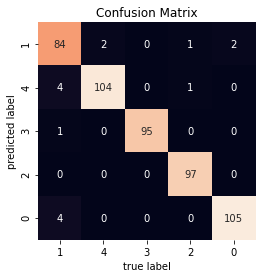

In [136]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

### Decision Trees

In [6]:
coded_ret_train['category'] = coded_ret_train['ret']
clf_tree_ret = sklearn.tree.DecisionTreeClassifier(max_depth=5,random_state=0)
clf_tree_ret.fit(np.stack(coded_ret_train['vect'], axis =0), coded_ret_train['category'])

DecisionTreeClassifier(max_depth=5, random_state=0)

In [7]:
# Training
train_dt_scores = lucem_illud.evaluateClassifier(clf_tree_ret, coded_ret_train)
train_dt_scores['Accuracy_Score'] = 1 - train_dt_scores['Error_Rate']
train_dt_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.389389,0.568259,0.594816,0.592613,0.942340,0.610611
positive,0.389389,0.568259,0.728457,0.498745,0.194177,0.610611


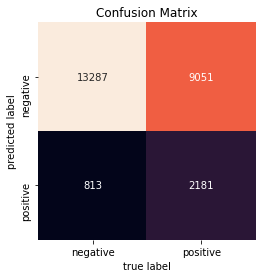

In [8]:
lucem_illud.plotConfusionMatrix(clf_tree_ret, coded_ret_train)

In [9]:
# Testing
coded_ret_test['category'] = coded_ret_test['ret']
test_dt_scores = lucem_illud.evaluateClassifier(clf_tree_ret, coded_ret_test)
test_dt_scores['Accuracy_Score'] = 1 - test_dt_scores['Error_Rate']
test_dt_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.414543,0.534625,0.582573,0.581319,0.933511,0.585457
positive,0.414543,0.534625,0.612403,0.460188,0.135739,0.585457


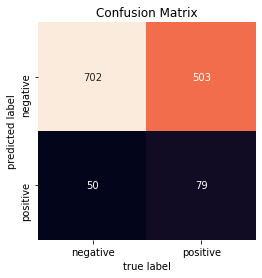

In [10]:
lucem_illud.plotConfusionMatrix(clf_tree_ret, coded_ret_test)

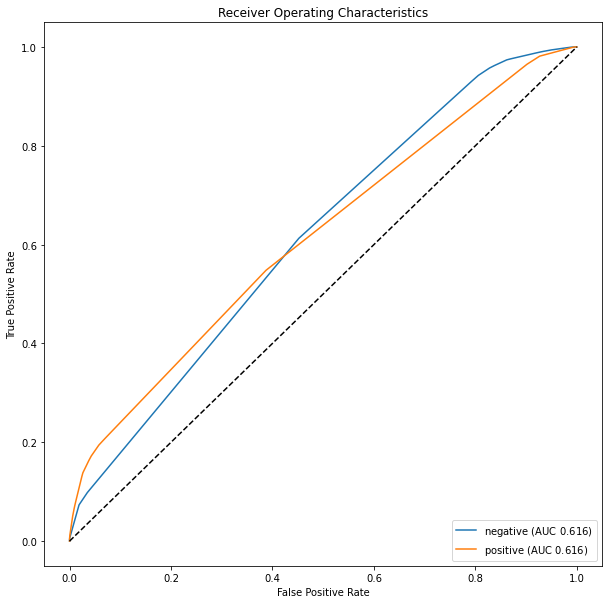

In [12]:
# ROC - training
lucem_illud.plotMultiROC(clf_tree_ret, coded_ret_train)

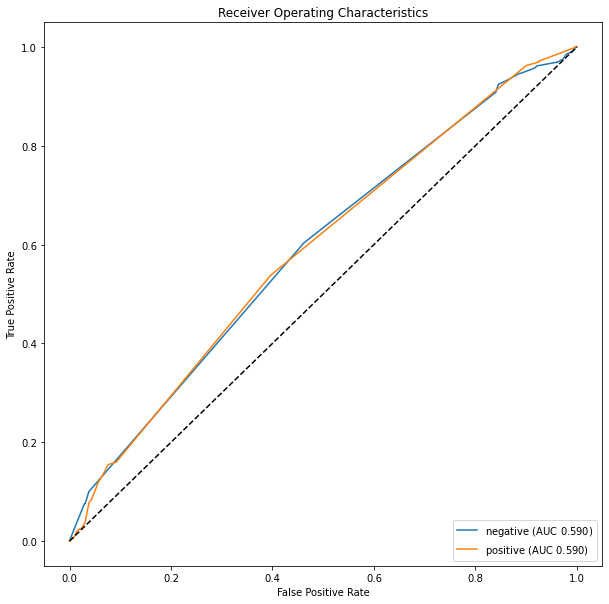

In [13]:
# ROC - testing
lucem_illud.plotMultiROC(clf_tree_ret, coded_ret_test)

Decision trees only make modest improvement.

### Random Forest Classification

In [14]:
rf_ret = sklearn.ensemble.RandomForestClassifier()
rf_ret.fit(np.stack(coded_ret_train['vect'], axis =0), coded_ret_train['category'])

RandomForestClassifier()

In [15]:
# Training
train_rf_scores = lucem_illud.evaluateClassifier(rf_ret, coded_ret_train)
train_rf_scores['Accuracy_Score'] = 1 - train_rf_scores['Error_Rate']
train_rf_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.000079,0.999911,0.999858,0.999858,1.000000,0.999921
positive,0.000079,0.999911,1.000000,0.999901,0.999822,0.999921


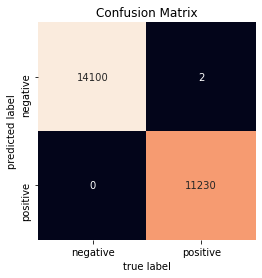

In [16]:
lucem_illud.plotConfusionMatrix(rf_ret, coded_ret_train)

In [17]:
# Testing
test_rf_scores = lucem_illud.evaluateClassifier(rf_ret, coded_ret_test)
test_rf_scores['Accuracy_Score'] = 1 - test_rf_scores['Error_Rate']
test_rf_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.292354,0.687283,0.698465,0.677859,0.847074,0.707646
positive,0.292354,0.687283,0.727488,0.589891,0.527491,0.707646


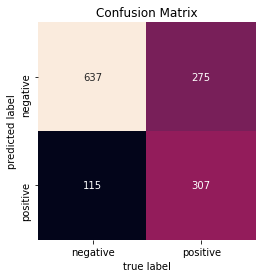

In [18]:
lucem_illud.plotConfusionMatrix(rf_ret, coded_ret_test)

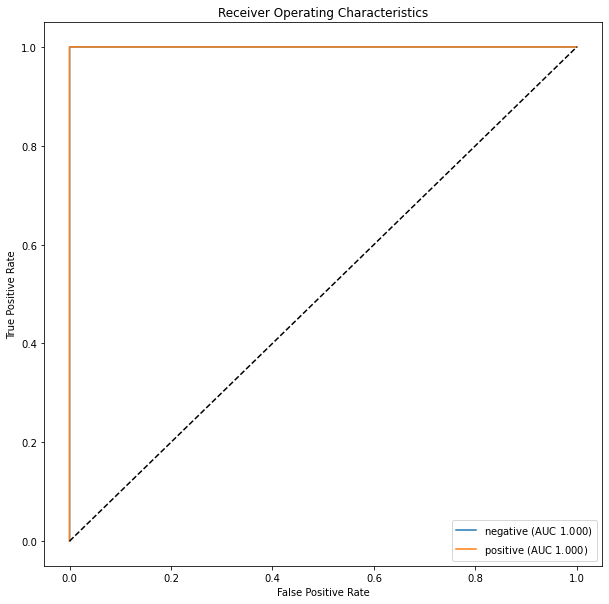

In [19]:
# ROC - training
lucem_illud.plotMultiROC(rf_ret, coded_ret_train)

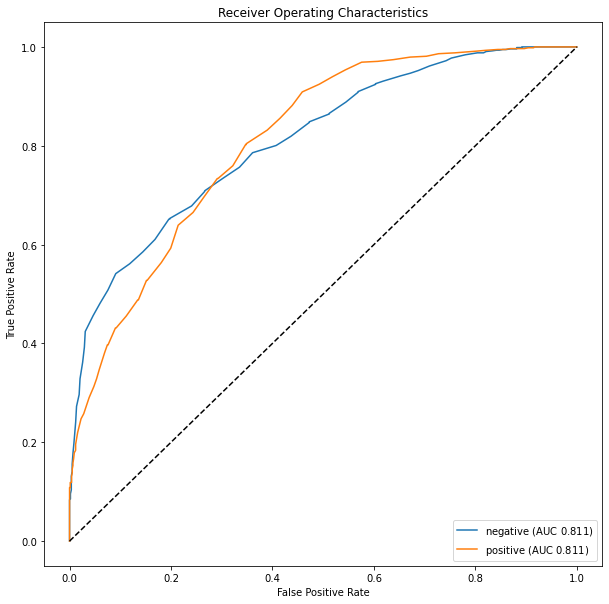

In [20]:
# ROC - testing
lucem_illud.plotMultiROC(rf_ret, coded_ret_test)

Random Forest significantly improves the performance! The test accuracy can reach 0.7 compared to 0.6 for best simple models. This suggests it is likely that there is complex non-linear relationship here that simple linear models cannot capture. It is worth noting that the training set achieves accuracy of nearly. The gap between training and test suggests that there may be some overfitting. And we may tune the model a little bit to reduce its complexity. In this way, it may achieve better performance.

### Ensemble

In [21]:
tree_ret = sklearn.tree.DecisionTreeClassifier(max_depth=10) 
bag_ret = sklearn.ensemble.BaggingClassifier(tree_ret, n_estimators=100, max_samples=0.8, random_state=1)
bag_ret.fit(np.stack(coded_ret_train['vect'], axis =0), coded_ret_train['category'])

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

In [22]:
# Training
train_bag_scores = lucem_illud.evaluateClassifier(bag_ret, coded_ret_train)
train_bag_scores['Accuracy_Score'] = 1 - train_bag_scores['Error_Rate']
train_bag_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.238513,0.733735,0.706129,0.702969,0.978865,0.761487
positive,0.238513,0.733735,0.948496,0.690188,0.488604,0.761487


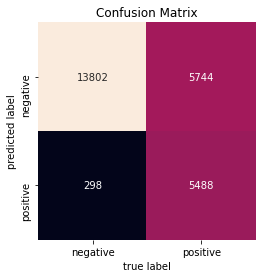

In [23]:
lucem_illud.plotConfusionMatrix(bag_ret, coded_ret_train)

In [24]:
# Testing
test_bag_scores = lucem_illud.evaluateClassifier(bag_ret, coded_ret_test)
test_bag_scores['Accuracy_Score'] = 1 - test_bag_scores['Error_Rate']
test_bag_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.35982,0.601612,0.625000,0.619133,0.904255,0.64018
positive,0.35982,0.601612,0.707317,0.517313,0.298969,0.64018


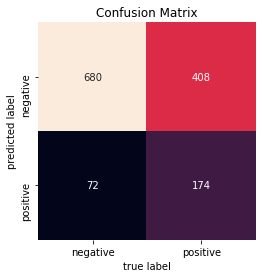

In [25]:
lucem_illud.plotConfusionMatrix(bag_ret, coded_ret_test)

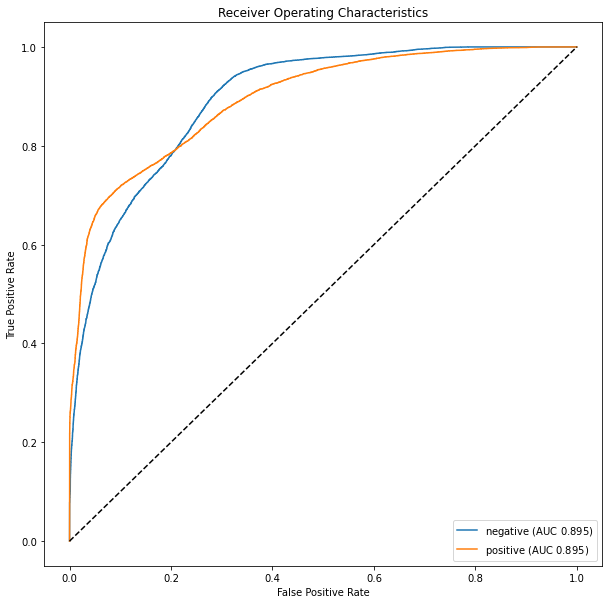

In [26]:
# ROC - training
lucem_illud.plotMultiROC(bag_ret, coded_ret_train)

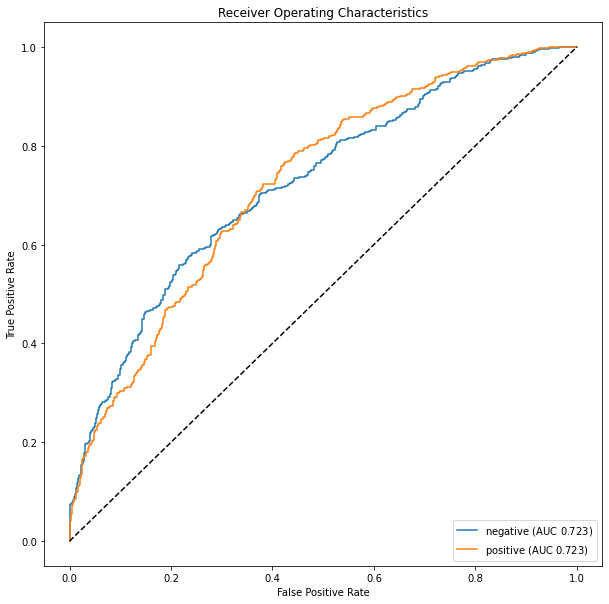

In [27]:
# ROC - testing
lucem_illud.plotMultiROC(bag_ret, coded_ret_test)

Ensemble model also does better than simple linear models. However, it does not outperform the random forest. It is also worth noting that ensemble beats simple CART model. This can be expected since ensemble is to combine several models to improve the stability and the final performance. 

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [137]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[be, sorry, read, commandment]"


Make a testing and training set:

In [139]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [140]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [141]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [142]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [143]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.254208,0.717618,0.549320,0.458129,0.651210
soc.religion.christian,0.248404,0.531729,1.000000,0.311861,0.063457
talk.religion.misc,0.264074,0.702843,0.357143,0.293279,0.652174
comp.graphics,0.294254,0.659122,0.467857,0.381552,0.556263


And lets look at the testing data

In [144]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.23255813953488372


Let's produce another confusion matrix:

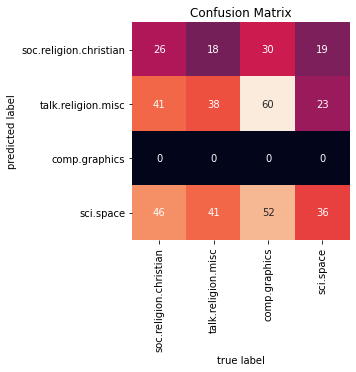

In [145]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [146]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [28]:
n_neighbors = 15
weights="uniform"
knn_ret = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
knn_ret.fit(np.stack(coded_ret_train['vect'], axis =0), coded_ret_train['category'])

KNeighborsClassifier(n_neighbors=15)

In [29]:
# Training
train_knn_scores = lucem_illud.evaluateClassifier(knn_ret, coded_ret_train)
train_knn_scores['Accuracy_Score'] = 1 - train_knn_scores['Error_Rate']
train_knn_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.262553,0.728039,0.741459,0.706547,0.811135,0.737447
positive,0.262553,0.728039,0.731200,0.629012,0.644943,0.737447


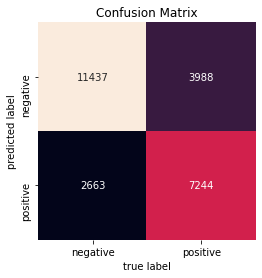

In [30]:
lucem_illud.plotConfusionMatrix(knn_ret, coded_ret_train)

In [31]:
# Testing
test_knn_scores = lucem_illud.evaluateClassifier(knn_ret, coded_ret_test)
test_knn_scores['Accuracy_Score'] = 1 - test_knn_scores['Error_Rate']
test_knn_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.351574,0.633397,0.667060,0.641362,0.751330,0.648426
positive,0.351574,0.633397,0.616016,0.528929,0.515464,0.648426


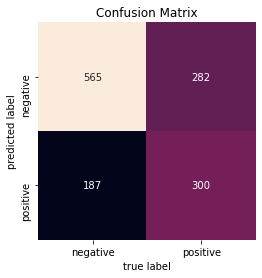

In [32]:
lucem_illud.plotConfusionMatrix(knn_ret, coded_ret_test)

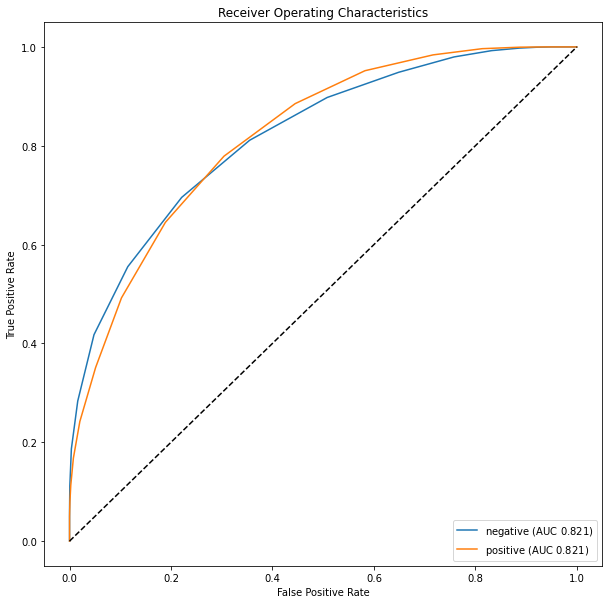

In [33]:
# ROC - training
lucem_illud.plotMultiROC(knn_ret, coded_ret_train)

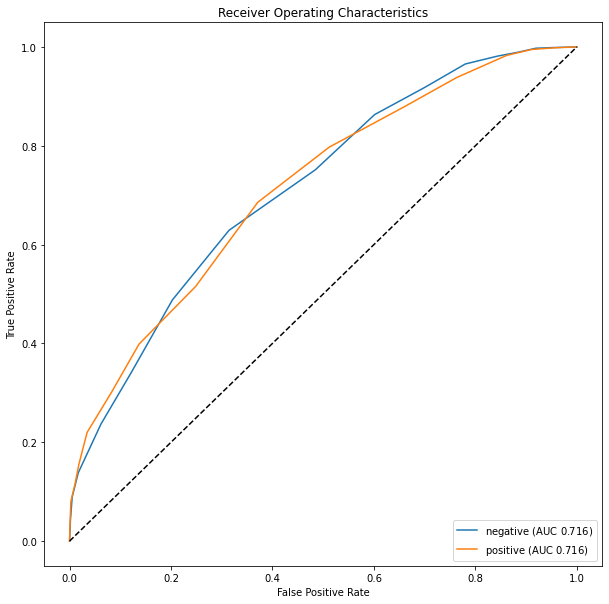

In [34]:
# ROC - testing
lucem_illud.plotMultiROC(knn_ret, coded_ret_test)

The K-nearest neighbors performs reasonably well, beating many simple models. It cannot outpeform the random forests. For the difference between KNN and K-means, although they both have 'K' in their names, their mechanism are different. First and foremost, KNN is supervised algorithm while K-means is unsupervised. For KNN, the label of a data point is determined by its close neighbors. For K-means, it is a clustering algorithm where we first divide data into several groups and we use the cluster centroid to label the data. Then we update the assignment of each point to its closest centroid. Then we repeat the centroid calculation step. The two procedures are run in sequence until some convergence criterion is satisfied.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [148]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [149]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [151]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [152]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [153]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.009404,0.980000,1.000000,0.969404,0.960000
Weeaboo Tales: stories about the extreme fans of japanese culture,0.003135,0.993151,1.000000,0.989436,0.986301
Bad Roommates: Tales of Irritation,0.012539,0.991342,0.956522,0.956522,1.000000
Tales From Tech Support,0.006270,0.991857,0.987952,0.979184,0.987952


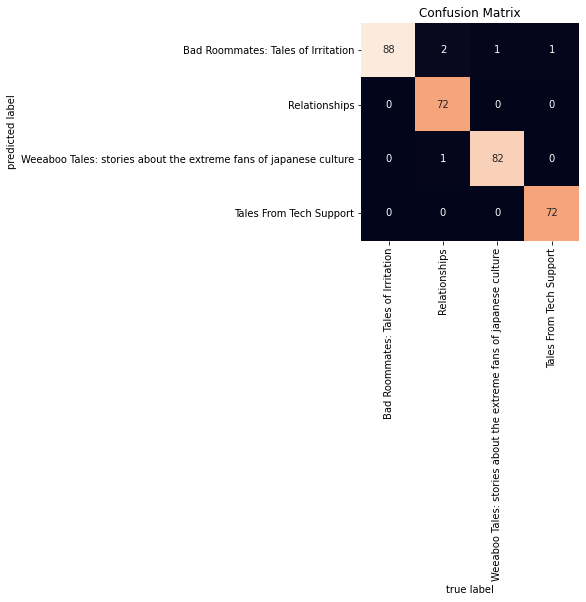

In [154]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

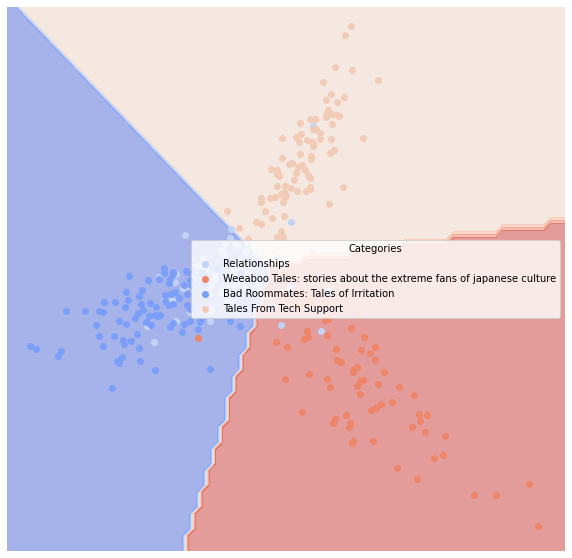

In [155]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [156]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [157]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.021944,0.967186,0.959459,0.920827,0.946667
Weeaboo Tales: stories about the extreme fans of japanese culture,0.009404,0.989086,0.972973,0.962779,0.986301
Bad Roommates: Tales of Irritation,0.025078,0.968615,0.954545,0.923696,0.954545
Tales From Tech Support,0.006270,0.991857,0.987952,0.979184,0.987952


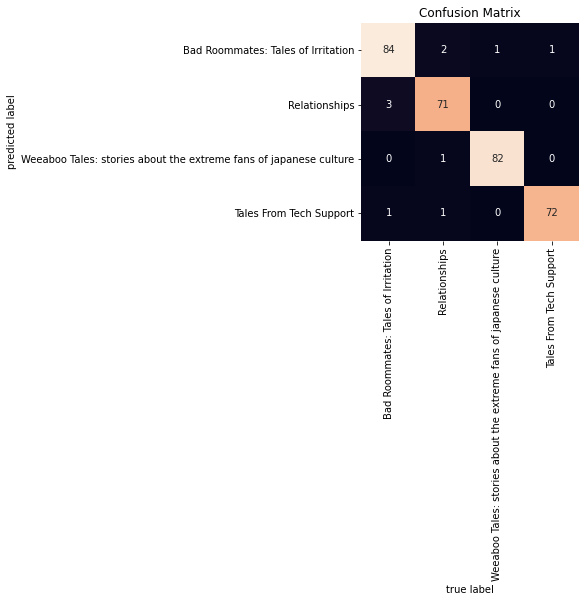

In [158]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

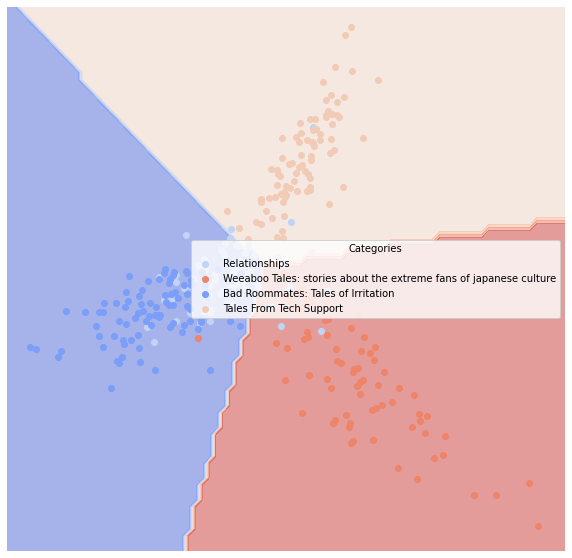

In [159]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [35]:
nn_ret = sklearn.neural_network.MLPClassifier()
nn_ret.fit(np.stack(coded_ret_train['vect'], axis =0), coded_ret_train['category'])

MLPClassifier()

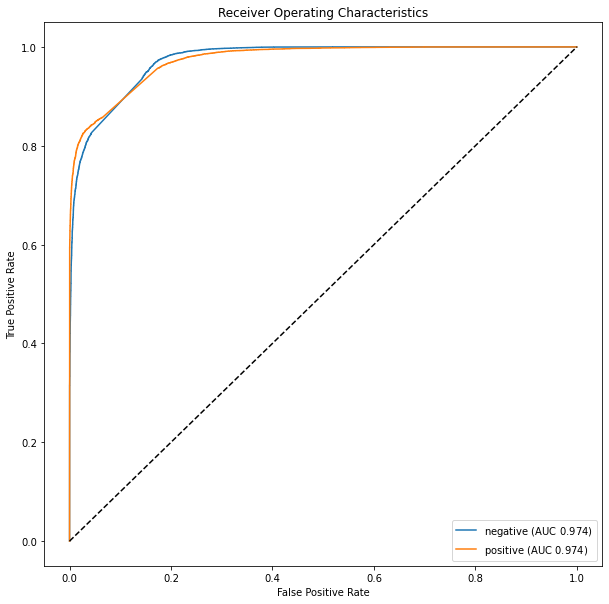

In [36]:
# ROC - training
lucem_illud.plotMultiROC(nn_ret, coded_ret_train)

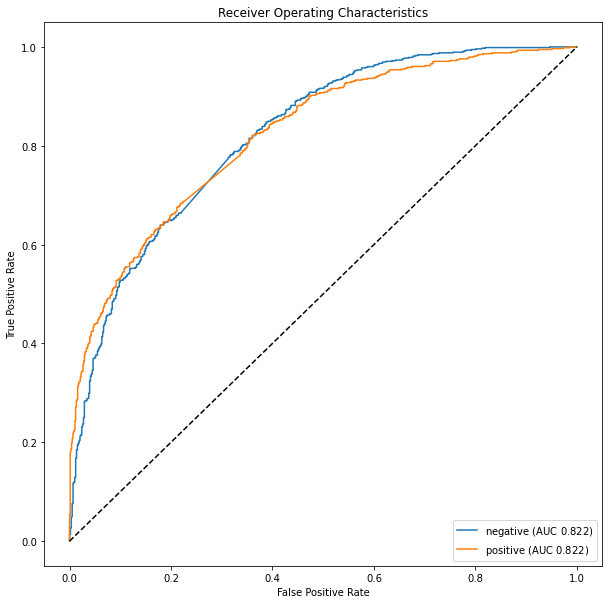

In [37]:
# ROC - testing
lucem_illud.plotMultiROC(nn_ret, coded_ret_test)

In [38]:
# Training
train_nn_scores = lucem_illud.evaluateClassifier(nn_ret, coded_ret_train)
train_nn_scores['Accuracy_Score'] = 1 - train_nn_scores['Error_Rate']
train_nn_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.095571,0.898376,0.885115,0.869295,0.951844,0.904429
positive,0.095571,0.898376,0.933228,0.857258,0.844907,0.904429


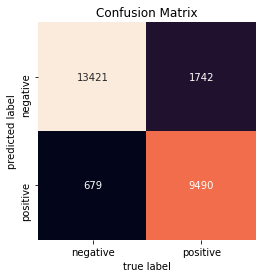

In [39]:
lucem_illud.plotConfusionMatrix(nn_ret, coded_ret_train)

In [40]:
# Testing
test_nn_scores = lucem_illud.evaluateClassifier(nn_ret, coded_ret_test)
test_nn_scores['Accuracy_Score'] = 1 - test_nn_scores['Error_Rate']
test_nn_scores

,Error_Rate,AUC,Precision,Average_Precision,Recall,Accuracy_Score
Category,,,,,,
negative,0.261619,0.731052,0.757344,0.716404,0.788564,0.738381
positive,0.261619,0.731052,0.711434,0.621608,0.673540,0.738381


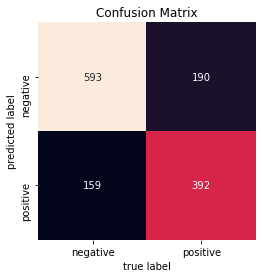

In [41]:
lucem_illud.plotConfusionMatrix(nn_ret, coded_ret_test)

#### Discussion on the Classification Algorithms

Finally, the neural network achieves the best performance among all the algorithms. I think the major reason is that it allows for a parsimonious treatment of complex non-linearity in the data. Comparing its performance to the random forest, the level of performance is similar in magnitude. Both achieve the accuracy of more than 0.7.

The best-performing simpler models such as logistic regression and naive bayes can only get an accuracy of 0.6. The performance for all other models all lie between 0.6 and 0.7.

It is also worth noting that the prediction of stock returns is inherently hard. There is much noise in the stock market compared to signals. Efficient market reinforces this. Prices reflect all available information and what is left over looks like random walk. Given this setup, we cannot expect the classification algorithm to reach near 100% accuracy. However, given the performance of prediction, we can see there is still some information in the textual documents that investors may not pay full attention to.

We are going to further use the textual information to build trading strategy to exploit such phenomenon.